Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [ ]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black

jupyter_black.load()

## Context
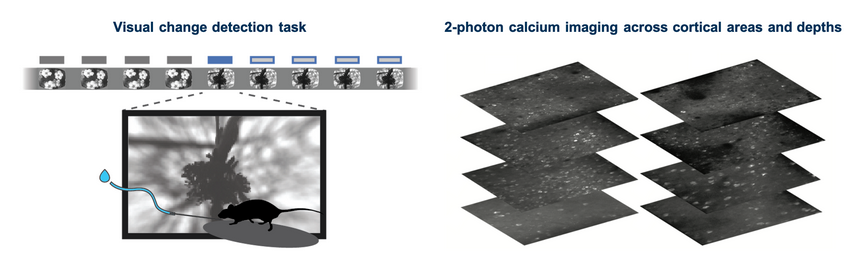

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

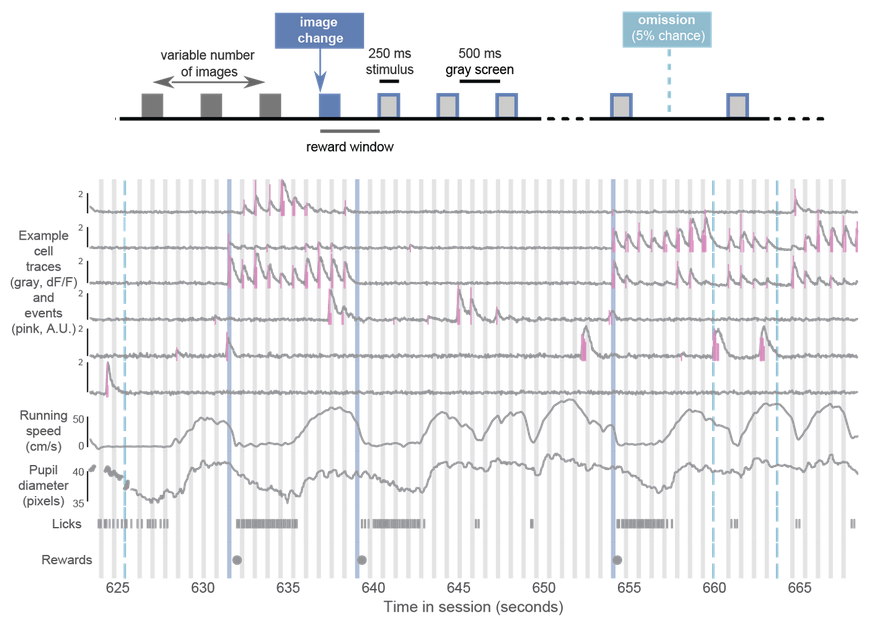

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [ ]:
# load data
def load_data(path="../data"):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



Was ich hier raus lese:
- wir haben 105968 Zeitpunkte, von denen müssen aber nicht alle berücksichtigt werden weil wohl auch andere Sachen gemessen wurden 
- wir haben 189 Zellen die wir beobachten. Diese wurden genetisch modifziert, sodass sie auf den GCaMP6f Indicator reagieren. Das ist der schnelle Calcium Indikator den wir in VL 3 besprochen haben
- für jede dieser Zellen gibt es eine Region of Intereset; offen: wie sieht diese aus? Das sollte man vielleicht mal für eine Zelle plotten? Identifzieren die ROIs bestimmte Zelltypen? 
- für alle ROI Masks (einzeln / zusammengerechnet über alle Zellen?) gibt es eine max_projection. Da diese nur 512x512 ist und nicht alle Zellen einzeln enthält gehe ich davon aus dass das über alle Zellen gemittelt/summiert ist - ich frage mich nur welchen Sinn das hat?
- es gibt eine running speed für jeden Zeitpunkt; in dem running speed data frame ist vermutlich auch pupil diameter enthalten, was oben geplottet ist. Daher 2 Messpunkte

Zu den Stimuli:
- in der stim_table ist angegeben, wann welcher Stimulus gezeigt wurde (frame, start, end) - passen hier die Dimensionen? Was ist dann in der Stim Table? Ggf kann man mal einige Stimuli sequentiell plotten um das Experiment besser nachvollziehen zu können? 

### Fragen:
Hier würde ich mal offene Fragen sammeln, die wir im Tut stellen wollen oder uns gegenseitig beantworten können.

- Wie sind die Messintervalle? Zeit in ms (oder noch genauer?) ?
- Wie genau ist der Zeitliche Ablauf des Experiments? Checkt das einer von euch? Was ist reward und wann kommt der?
- the preprocessed activity traces (df/f) -> Was genau heißt hier pre-processed? Ist Pre-Processing nicht unsere erste Aufgabe? Ich nehme mal nicht an dass die Spkies schon identifiziert sind? 
- dürfen wir bspw. den oopsi Algorithmus zur spike detection nehmen und den einfach importieren? also mit oopsi.py? oder muss man so etwas slebst in einer util implementieren? 
- Identifizieren die ROIs bestimmte Zelltypen? (weil irgendwie müssen die Zelltypen ja idtifiziert werden, es gibt ja Bonus points wenn man sich einige Typen genauer anschaut ^^) -> aus Vorlesung: Ja! Man hat effektiv ein Bild, wo man alle Zellen sieht, auf diesem sind individuelle Zellen dann abgegrenzt (Segmentierung)... Theoretisch könnte man über die Form / Positionierung Zelltypen identifzieren i guess? Dazu wurde in der VL nichts gesagt meine ich

## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

### Erstes Drama: Plotting, um die Daten besser zu verstehen. 
Ich würde sagen es ist sinnvoll, folgende Plots einmal selbst zu machen:

- Time + Activity traces für 5 Zellen ( + Pupil / Running für den geplotteten Zeitabschnitt) (wie oben einfach zum nachvollziehen)
- ROI für 5 Zellen (die selben wie oben idealerweise) - das sollten Bilder sein, oder? Einfach nebeneinander plotten i guess?
- ROI Max (sollte ein Bild sein, oder? Schwarz weiß?)

- Die Stimuli und wie sie sich verändern; da ich die Stimuli noch nicht ganz verstanden hab, kann ich nicht so genau sagen was hier sinnvoll wäre...

by the way sehr nice musik: https://www.youtube.com/watch?v=rSDoXnslLsg

In [ ]:
# TODO: aufi plotti

### Zweites Thema: Preprocessing + und Spike Detection
Ich meine man sollte preprocessing abhänig davon machen, welchen Detection Algorithmus man verwenden will.

Hier einige Gedanken aus den bisherigen Notbooks/ Vorlesungen:
- Wir haben erst gefiltert und dann die spike trains inferiert; da es sich hier um Calcium Daten handelt sollten wir vermutlich dem in VL 3 vorgeschlagenen Paper von Yaksi & Friedrich folgen; die machen Filtering und Deconvolution der neuronalen Aktivität

Yaksi, E., Friedrich, R. Reconstruction of firing rate changes across neuronal populations by temporally deconvolved Ca2+ imaging. Nat Methods 3, 377–383 (2006). https://doi.org/10.1038/nmeth874

Hier grob die Schritte, die man gehen könnte; 1 und 2 haben wir damals im Notebook geskippt! (war nicht Aufgabe) --> Das ist das Preprocessing, das wir dieses mal machen müssen!
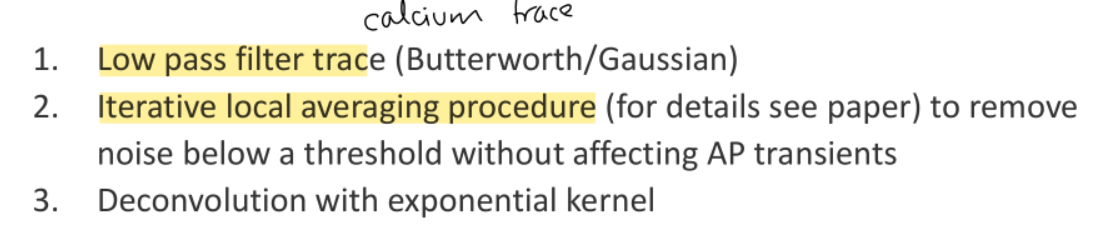


Für die Deconvolution an sich kann man sich dann überlegen, welchen Algorithmus man verwenden will; entweder man macht nur einen einfach Kernel oder man versucht dieses oopsi ODER einen der anderen Algorithmen, die vorgestellt wurden; wir hatten damals nur oopsi implementiert. Da wir keine Ground Truth Daten haben kann man die Algorithmen nicht wirklich sinnvoll statistisch vergleichen...
TODO: Hier eine Entscheidungsmöglichkeit finden.


Schritte im Preprocessing:

1. First Low pass filter; Butterworth or Gaussian (Das sagen die im Paper nicht genau, sie sagen "or") --> CL 1, Aufgabe 1: 
"low-pass Butterworth or Gaussian filter with a cutoff frequency minimizing the distortion of sharply rising Ca2+ transients."
"In most cases, we used a 4-pole Butterworth filter with a cutoff frequency equal to 0.2 times the frame rate"

2. further filtered with an algorithm that smoothes peak with ampltiudes below a threshold --> das ist genauer in der PDF 2_iterativeSMoothing beschrieben; muss man glaube ich nicht machen wäre aber sicherlich cool; effektiv identifziert man iterativ den smallest peak in einem Intervall (d.h. nicht den lowest value sondern den smallest peak relativ zu den anderen werten, also den wert des am wenigsten von seinen anderen Werten in Umkreis von x timesteps abweicht! in CL 1 haben wir für eine ähnliche Aufgabe die Funktion scipy.signal.find_peaks verwendet - hier muss man sich nur die Dokumentation nochmal anschauen um die richtigen Peaks zu finden); dann nimmt man den den Peak und macht ein local averaging über die untersuchte Zeitspanne (also wenn wir einen PEak in 10 ms window suchen dan averagen wir auch über diese 10 ms und setzen alle Werte in dem Window auf den average); das ganze dann iterativ wiederholen bis man keien Veränderungen mehr hat (wie auch immer das möglich sein soll) oder bis man max it (5000) erreicht hat; ich denke hier muss man dann im Nachgang noch viel Parameter tweaking machen (wie groß ist das search window, wie viele iterationen?) um gute Ergebnisse zu bekommen; auch hier immer RAW Data mit gesmoothed plotten pls (wenn wir den Schritt machen wollen)

In [ ]:
### FILTERING #############################

# 1. Code aus CL 1

'''
y = x.apply(
    lambda col: signal.sosfiltfilt(  # apply the filter to all columns
        signal.butter(  # apply the filter to a column
            order,
            [low / (fs / 2), high / (fs / 2)],  # frequency thresholds (normalized)
            btype="band",  # filter type
            analog=False,
            output="sos",  # second-order sections
        ),
        col,
    )
)

xf = filter_signal(x, fs, 300, 3000, order=5)
'''

#Das haben wir für die electrophys Daten verwendet, ich würde das so machen wie oben beschrieben; aber nur nochmal als Reminder!
# Filter: Butterworth with bandwidth 300-6000 used by
# Yael D, Bar-Gad I. Filter based phase distortions in extracellular spikes. PLoS One. 2017 Mar 30;12(3):e0174790. doi: 10.1371/journal.pone.0174790
# But: 3000 HZ seems to be more reasonable in our case as it trims down the signal a little more
# Downside of larger trim: the PCA becomes a little denser


In [ ]:
# Hier würde ich unbedingt auch die raw signals gegenüber den gefilterten Signals plotten

Thema Smoothing: 
- oopsi hat einfach nen wiener filter gemacht, aber im Algorithmus an sich wird nicht nochmal gefiltert; man könnte drüber nachdenken ob wir auch einen Wiener Filter haben wollen? Mein Gedanke dazu: wiener filter ist auch low pass, angepasst an SNR wenn ich das richtig verstehe; mit Butterworth und dem Smoothing erreicht man ja effektiv das gleiche? Weil das Smoothign ist ja auch abh. vom SNR und verbessert dieses, oder?

- c2s ist ein ML Algorithmus; das Preprocessing da ist beschrieben mit: https://github.com/lucastheis/c2s/blob/master/c2s/c2s.py#L166
This [preprocessing] function does three things:
    1. Remove any linear trends using robust linear regression.
    2. Normalize the range of the calcium trace by the 5th and 80th percentile.
    3. Change the sampling rate of the calcium trace and spike train.
Hier ehrlich gesagt keine Ahnung ob wir dann noch preprocessen sollen oder nicht

- OASIS: https://papers.nips.cc/paper_files/paper/2016/hash/fc2c7c47b918d0c2d792a719dfb602ef-Abstract.html; der Algorithmus ist aber wohl eher für Online Processing, was wir ja nicht wollen; gefiltert / gepreprocessed wird hier wohl nichts

Fazit zum Smoothing im Hinblick auf die Spike Inference: Ich denke wir fahren gut wenn wir es implementieren, da es für oopsi und simple deconv auf jeden Fall sinnvoll ist.

In [ ]:
### SMOOTHING #############################
# TODO: Wollen wir das Smoothing machen? So viel Arbeit ist es denke ich nicht oder?

In [ ]:
#samesies mit den plotties - bitte verkünsteln, danke

#### Zweiter Teil vom zweiten Drama: Deconvolution (mit versch. Algorithmen?) & Spike Detection

Hier kann man entweder einfache deconvolution machen mit einem einfachen expoentiellen Kernel ( $y = exp(−t/ \tau$), wie im Yaksi und Friedrich Paper oder man kann fancigere Sachen machen: In CL 3 werden hier diese drei verschiedenen Algorithmen verlinkt

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

Das kommt mMn ein bisschen drauf an, ob man die Algorithmen einfach importieren darf? :D Ansonsten würde ich hier die simple deconv und Oopsie einmal umsetzen, wie im CL 3. Dann die beiden visuell vergleichen und dann argumentieren dass oopsie besser ist und auf die Benchmarking Studie vom Berens (c2s Paper) verweisen, damit begründen warum wir uns für den einen Algorithmus dann entschieden haben. Allerdings müsste man dann fast den c2s von denen nehmen, der ist nähmlich nochmal besser; Hier das Bild dazu (MAP von Vogelstein ist der OOPSI Algorithmus; STM ist der c2s von denen)

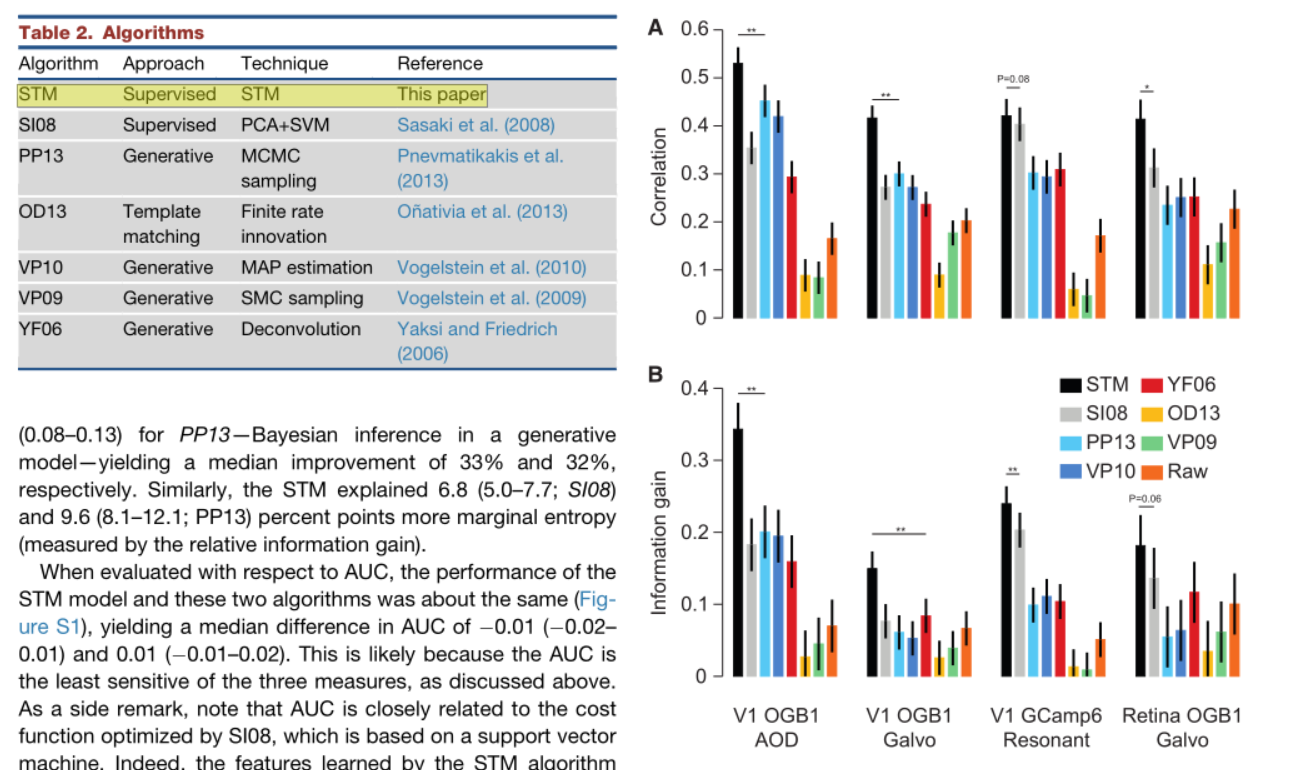
